# 10. 시계열 분석

**감사말**: 프랑소와 숄레의 [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff) 9장에 사용된 코드에 대한 설명을 담고 있으며 텐서플로우 2.6 버전에서 작성되었습니다. 소스코드를 공개한 저자에게 감사드립니다.

**구글 코랩 설정**

'런타임 -> 런타임 유형 변경' 메뉴에서 GPU를 지정한다.
TensorFlow 버전을 확인하려면 아래 명령문을 실행한다.

In [ ]:
import tensorflow as tf
tf.__version__

'2.8.3'

TensorFlow가 GPU를 사용하는지 여부를 확인하려면 아래 명령문을 실행한다.
아래와 같은 결과가 나오면 GPU가 제대로 지원됨을 의미한다.

```
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
```

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

**참고**

아래 코드에 대한 자세한 설명은
[시계열 데이터 분석](https://codingalzi.github.io/dlp2/dl_for_timeseries.html)을 참고한다.

## 10.1 시계열 분석 사례

## 10.2 시계열 분석 사례: 온도 예측

### 10.2.1. 데이터셋 준비

독일 예나<font size='2'>Jena</font>시에 위치한 
막스-플랑크 생지화확<font size='2'>Max-Planck Biogeochemistry</font> 연구소가
온도, 기압, 풍향 등 14 종류의 기상 데이터를 10분 단위로 측정해서 수집한 데이터셋이다. 
원래 2003년부터 측정하였지만 여기서는 2009-2016년 데이터를 이용한다. 

**zip 파일 다운로드 및 압축풀기**

"jena_climate_2009_2016.csv" 파일이 생성된다.

In [1]:
if 'google.colab' in str(get_ipython()):
    !wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
    !unzip jena_climate_2009_2016.csv.zip
else: 
    try: 
        import wget, zipfile
    except ModuleNotFoundError: 
        !pip install wget
        
    import wget, zipfile
    wget.download('https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip')
    with zipfile.ZipFile('jena_climate_2009_2016.csv.zip', 'r') as zip_ref:
        zip_ref.extractall('./')

100% [........................................................................] 13565642 / 13565642

**예나(Jena) 날씨 데이터셋 살펴보기**

파일을 열어 줄(line) 단위로 쪼갠다.

In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")

첫째 줄은 날짜와 시간 이외에 14개의 특성명이 쉼표(콤마)로 구분되어 있으며,
총 420,451개의 데이터를 포함한다.

In [3]:
header = lines[0].split(",")
lines = lines[1:]

In [4]:
print(header)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


In [5]:
print(len(lines))

420451


첫째 데이터는 2009년 1월 1일 0시 10분에 측정되었다.

In [6]:
lines[0]

'01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30'

쉼표를 기준으로 문자열을 쪼개면 다음과 같다.

In [7]:
lines[0].split(',')

['01.01.2009 00:10:00',
 '996.52',
 '-8.02',
 '265.40',
 '-8.90',
 '93.30',
 '3.33',
 '3.11',
 '0.22',
 '1.94',
 '3.12',
 '1307.75',
 '1.03',
 '1.75',
 '152.30']

2번 인덱스 항목이 섭씨 온도이다. 

In [8]:
lines[0].split(',')[2]

'-8.02'

**넘파이 어레이로 변환**

In [9]:
import numpy as np

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]

    temperature[i] = values[1]    # i 번째 온도
    raw_data[i, :] = values[:]    # i 번째 데이터

**온도 변화 그래프**

온도의 변화를 선그래프로 그리면 다음과 같다.

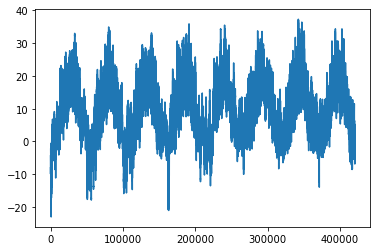

In [10]:
from matplotlib import pyplot as plt

plt.plot(range(len(temperature)), temperature)

**처음 10일동안의 온도 변화**

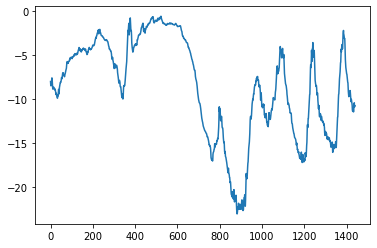

In [11]:
plt.plot(range(1440), temperature[:1440])

**훈련셋, 검증셋, 테스트셋 지정하기**

각 데이터셋의 크기는 다음과 같다.

- 훈련셋: 전체의 50%
- 검증셋: 전체의 25%
- 테스트셋: 전체의 25%

미래에 대한 예측을 실행하므로 훈련셋, 검증셋, 테스트셋 순으로 
보다 오래된 데이터를 사용한다. 

In [12]:
num_train_samples = int(0.5 * len(raw_data))     # 전체의 50%
num_val_samples   = int(0.25 * len(raw_data))    # 전체의 25%
num_test_samples  = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples:\t", num_train_samples)
print("num_val_samples:\t", num_val_samples)
print("num_test_samples:\t", num_test_samples)

num_train_samples:	 210225
num_val_samples:	 105112
num_test_samples:	 105114


**데이터 정규화**

In [13]:
# 훈련셋의 평균
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean

# 훈련셋의 표준편차
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

**5일 단위 시퀀스 데이터 준비**

앞서 언급한 문제의 해결을 위한 모델을 구현하려면
5일 단위 시퀀스 데이터를 준비해야 하지만
`timeseries_dataset_from_array()` 함수를 활용하면 아주 쉽게 해결된다.

In [14]:
from tensorflow import keras

# 1시간에 하나의 데이터 선택
sampling_rate = 6

# 입력 데이터 시퀀스: 지난 5일치(120시간) 온도 데이터
sequence_length = 120

# 타깃 설정:24시간 이후의 온도. 지연(delay)을 6일치로 지정
delay = sampling_rate * (sequence_length + 24 - 1)

# 배치 크기
batch_size = 256

# 훈련셋
train_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True, # 생성된 시퀀스들의 순서 무작위화
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

# 검증셋
val_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

# 테스트셋
test_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

생성된 새로운 데이터셋은 훈련셋의 샘플과 타깃을 함께 배치 단위로 묶여있다.
예를 들어, 훈련셋의 첫째 배치의 모양은 다음과 같다.

- 배치 크기: 256
- 시퀀스 샘플 모양: `(120, 14)`, 즉 14개의 특성을 갖는 날씨 5일치 데이터.

In [15]:
for samples, targets in train_dataset:
    print("샘플 모양:", samples.shape)
    print("타깃 모양:", targets.shape)
    break

샘플 모양: (256, 120, 14)
타깃 모양: (256,)


### 10.2.2. 간단한 순환 모델 성능

**모델 성능의 베이스라인 설정**

모델 성능의 최저 기준선으로 24시간 후의 온도를 현재 온도로 예측하는 것을 사용한다.
즉, 내일 이 시간 온도가 현재 온도와 별 차이가 없다는 가정을 이용한다. 
그러면 검증셋과 테스트셋에 대한 평균절대오차는 각각 2.44와 2.62이다.

In [20]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        # 현재 온도를 예측값으로 사용
        preds = samples[:, -1, 1] * std[1] + mean[1]     # 평균과 표준편차를 되돌려서 타깃으로 지정
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"검증셋 평균절대오차(MAE): {evaluate_naive_method(val_dataset):.2f}")
print(f"테스트셋 평균절대오차(MAE): {evaluate_naive_method(test_dataset):.2f}")

검증셋 평균절대오차(MAE): 2.44
테스트셋 평균절대오차(MAE): 2.62


아래 코드는 가장 간단한 순환 신경망 모델이더라도 베이스라인과 유사하거나 좀 더 좋은 성능을 보여준다.

In [25]:
from tensorflow import keras 
from tensorflow.keras import layers

# 모델 구성
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

# LSTM 층
x = layers.LSTM(16)(inputs)

# 출력층
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]

# 모델 컴파일 및 실행
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 16s 17ms/step - loss: 41.4105 - mae: 4.6696 - val_loss: 12.3946 - val_mae: 2.6863
Epoch 2/10
819/819 [==============================] - 14s 17ms/step - loss: 11.0485 - mae: 2.5860 - val_loss: 9.6549 - val_mae: 2.4154
Epoch 3/10
819/819 [==============================] - 14s 17ms/step - loss: 9.9441 - mae: 2.4608 - val_loss: 9.7519 - val_mae: 2.4207
Epoch 4/10
819/819 [==============================] - 14s 16ms/step - loss: 9.5458 - mae: 2.4071 - val_loss: 9.4256 - val_mae: 2.3791
Epoch 5/10
819/819 [==============================] - 14s 17ms/step - loss: 9.2322 - mae: 2.3655 - val_loss: 9.5067 - val_mae: 2.3857
Epoch 6/10
819/819 [==============================] - 14s 17ms/step - loss: 8.9148 - mae: 2.3218 - val_loss: 9.6452 - val_mae: 2.4019
Epoch 7/10
819/819 [==============================] - 14s 17ms/step - loss: 8.6313 - mae: 2.2886 - val_loss: 9.6782 - val_mae: 2.4281
Epoch 8/10
819/819 [==============================] - 13s 1

학습과정을 그래프로 나타내면 다음과 같다. 

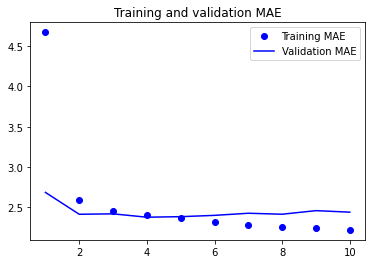

In [26]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## 10.3 순환 신경망 이해

## 10.4 순환 신경망 고급 활용법

**순환 드랍아웃 적용**

아래 코드는 LSTM 층에 `recurrent_dropout=0.25` 옵션을 사용해서 모델을 훈련한다.

- 순환 드랍아웃을 사용하기에 층의 유닛 수를 이전보다 두 배로 늘림.
- 과대적합이 보다 늦게 발생할 것을 대비해 에포크 수를 50으로 늘림.

**주의사항:** 아래 코드는 CPU 성능에 따라 몇 시간 이상 실행될 수 있다.

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

학습과정을 그래프로 나타내면 다음과 같으며, 과대적합이 20 에포크 이후에 
발생함을 확인할 수 있다.
동시에 모델의 성능도 좋아졌다. 

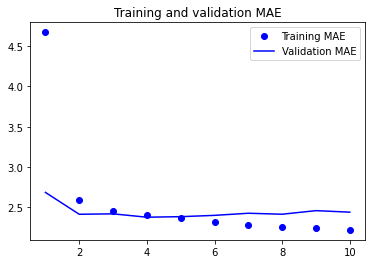

In [ ]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**순환층 쌓기**

순환층으로 스택으로 쌓아서 활용할 수도 있다.
아래 모델은 LSTM의 변종이면서 좀 더 가벼운 GRU(Gated Recurrent Unit) 층을 사용한다.
마지막 순환층을 제외한 모든 순환층에서 `return_sequences=True` 옵션을 
지정해야 함에 주의해야 한다. 

**주의사항:** 아래 코드는 CPU 성능에 따라 몇 시간 이상 실행될 수 있다.

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

학습과정을 그래프로 나타내면 다음과 같으며 모델의 성능이 좀 더 좋아졌다.
하지만 층을 더 이상 쌓는다고 해서 성능이 반드시 더 좋아진다는 보장은 없으며
오히려 나빠질 수도 있다.

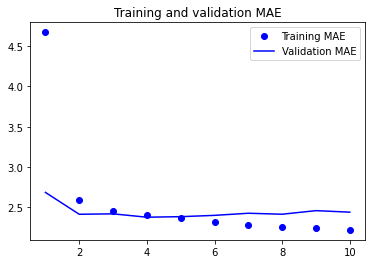

In [ ]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()